In [ ]:

#!/usr/bin/env python
# coding: utf-8

import os
# import args
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta  
from functools import reduce
# from sklearn.model_selection import train_test_split

def line_plot(df, var, title=False):
    fig, ax = plt.subplots(figsize=(10,5), dpi=100)
    plt.style.use('seaborn-ticks') # print(plt.style.available)
    if title:
        plt.title(title, fontsize=22)

    df.reset_index().plot.line(x= 'date', y = var, ax=ax, color="black").grid(alpha=.4)
    ax.get_legend().remove()
#     fig.savefig(_charts + "\\" + segname + "_MON.png", bbox_inches = 'tight', pad_inches = 0)

def get_return(df, var):
    df['G1'] = df[var].pct_change(1)
    df['N1'] = np.log(df[var].pct_change(1)+1)
    
    df['G5'] = df[var].pct_change(5)
    df['N5'] = np.log(df[var].pct_change(5)+1)
    
    df['G1_mon'] = df[var].pct_change(25)
    df['N1_mon'] = np.log(df[var].pct_change(25)+1) 
    
    df['G6_mon'] = df[var].pct_change(125)
    df['N6_mon'] = np.log(df[var].pct_change(125)+1)  
    
    # df['G1_yr'] = df[var].pct_change(250)
    # df['N1_yr'] = np.log(df[var].pct_change(250)+1)   
    
    # df['G2_yr'] = df[var].pct_change(500)
    # df['N2_yr'] = np.log(df[var].pct_change(500)+1)
    
#     df['MA2'] = df[var].rolling(2, min_periods=2).mean()
    df['MA32'] = df[var].rolling(32, min_periods=1).mean()
    df['MA16'] = df[var].rolling(16, min_periods=1).mean()
    df['MA4'] = df[var].rolling(4, min_periods=1).mean()
    df['EMA'] = df[var].ewm(alpha=0.5).mean()
    return df[126:]
    # return df

def get_return_std(df, y):
    df['R12_std'] = df[y].rolling(12,min_periods = 2).std()
    df['R25_std'] = df[y].rolling(25,min_periods = 2).std()
    df['R50_std'] = df[y].rolling(50, min_periods = 2).std()
    return df[2:]

def get_holidays(df):
    date = datetime.strptime(df.date.min(), "%Y-%m-%d")
    end_date = datetime.strptime(df.date.max(), "%Y-%m-%d")
    holidays = []
    while date <= end_date:
        if date.weekday()<=4:
            date = date.strftime("%Y-%m-%d")
            if date not in list(df.date):
                holidays += [date]
            date = datetime.strptime(date, "%Y-%m-%d")
        date += timedelta(1)
    return holidays

# --- Feature Engineering: return, s.d. of return, weekday, holiday, etc. ---
def get_state(df):
    df = get_return(df, 'close')
    df = get_return_std(df, 'N1')
    # keep states needed
    df = df[['date', 'close', 'vol'] + list(df.filter(regex='^N|^R|^MA'))]
    return df

def get_training_set(dic):
    train = {}
    for key, value in dic.items():
        # train[key] = value.loc[(value.date >= start_date) & (value.date < end_date)].reset_index(drop=True)
        train[key] = value
        train[key] = get_state(train[key])
        train[key] = train[key].iloc[:2200].reset_index(drop=True)
        train[key]['weekday'] = pd.to_datetime(train[key].date).dt.dayofweek
    return train  

# save 500 days to calculate 2-year return
def get_test_set(dic):
    test = {}
    for key, value in dic.items():
        # test[key] = value.iloc[int(value.index[value.date==end_date].values - 500):].reset_index(drop=True)
        test[key] = value
        test[key] = get_state(test[key])
        test[key] = test[key].iloc[2200:].reset_index(drop=True)
        test[key]['weekday'] = pd.to_datetime(test[key].date).dt.dayofweek
    return test  

def get_holiday_dummy(dic):
    one_day_before_holiday = list((pd.to_datetime(holidays) - timedelta(1)).strftime("%Y-%m-%d"))
    two_day_before_holiday = list((pd.to_datetime(holidays) - timedelta(2)).strftime("%Y-%m-%d"))
    three_day_before_holiday = list((pd.to_datetime(holidays) - timedelta(3)).strftime("%Y-%m-%d"))
    three_day_after_holiday = list((pd.to_datetime(holidays) + timedelta(3)).strftime("%Y-%m-%d"))
    two_day_after_holiday = list((pd.to_datetime(holidays) + timedelta(2)).strftime("%Y-%m-%d"))
    one_day_after_holiday = list((pd.to_datetime(holidays) + timedelta(1)).strftime("%Y-%m-%d"))

    for key, value in dic.items():
        df = dic[key]
        df['before_holiday_1'] = df.date.apply(lambda x: 1 if (x in one_day_before_holiday) else 0)
        df['before_holiday_2'] = df.date.apply(lambda x: 1 if (x in two_day_before_holiday) else 0)
        df['before_holiday_3'] = df.date.apply(lambda x: 1 if (x in three_day_before_holiday) else 0)
        df['after_holiday_1'] = df.date.apply(lambda x: 1 if (x in one_day_after_holiday) else 0)
        df['after_holiday_2'] = df.date.apply(lambda x: 1 if (x in two_day_after_holiday) else 0)
        df['after_holiday_3'] = df.date.apply(lambda x: 1 if (x in three_day_after_holiday) else 0)
    return dic

# load stocks
# data_folder = args._daily
data_folder = '/content/stock_prediction/data/nifty'
os.chdir(data_folder)
stock = [x.replace('.csv', '') for x in os.listdir(data_folder)]
# stock = [x for x in stock if x!='GOOGL' and x!='ALLY' and x!='WAL']

# stock = ['SPX', 'BA', 'MS']
tables = [pd.read_csv(x + ".csv") for x in stock if x!='.ipynb_checkpoints']
os.chdir('/content')
# stock = ['SBIN', 'nifty']
# tables = [pd.read_csv(x + ".csv") for x in stock ]
# dt_sbi = pd.read_csv('SBIN.csv')
# dt_sbi = dt_sbi[:3105]
# dt_nifty = pd.read_csv('nifty.csv')

# df_nifty = pd.DataFrame(columns=dt_nifty.columns)
# df_sbi = pd.DataFrame(columns=dt_nifty.columns)

# for i in range(len(dt_sbi)):
#     df_nifty.loc[i] = dt_nifty.loc[len(dt_nifty)-i-1]
#     df_sbi.loc[i] = dt_sbi.loc[len(dt_sbi)-i-1]


# tables = [df_sbi, df_nifty]
# tables = pd.read_csv(stock+'.csv')
stock_d = dict(zip(stock, tables)) # line_plot(stock_d['SPX'], 'close', 'SPX')
# clean a bit
# print(stock_d['SBIN'])
for each in stock:
    # stock_d[each] = stock_d[each].rename(columns={'4. close': 'close', '5. volume': 'vol'})
    stock_d[each] = stock_d[each].rename(columns={'Date': 'date','Adj Close': 'close', 'Close': 'ignore', 'Volume': 'vol'})

# env para
start_date = max([value.date.min() for key, value in stock_d.items()])
end_date = '2020-04-21'
worth = 100000
bottom_line = worth * 0.95
cycle = 60

# get train and test
train = get_training_set(stock_d)
test = get_test_set(stock_d)
# holidays = get_holidays(train['SPX']) + get_holidays(test['SPX']) 
# train = get_holiday_dummy(train)
# test = get_holiday_dummy(test)
# train['SPX']['close'] = train['SPX']['close']/10

for key, df in train.items():
    train[key].fillna(method = 'backfill',inplace = True)

for key, df in test.items():
    test[key].fillna(method = 'backfill',inplace = True)




def add_days(date, days):
    new_datetime = datetime.strptime(date, "%Y-%m-%d") + timedelta(days)
    new_date = new_datetime.strftime("%Y-%m-%d")
    return new_date

def add_one_trade_day(date):
    date = add_days(date, 1)
    # while (datetime.strptime(date, "%Y-%m-%d").weekday()>=5) or (date in holidays):
    while (datetime.strptime(date, "%Y-%m-%d").weekday()>=5):
        date = add_days(date, 1) 
    return date

def concat(x,y): return pd.concat([x,y], axis=0).reset_index(drop=True)

def get_info(env, date):
    info_matrix = []
    for key, df in env.items():
        df['stock'] = key
        a = df.loc[df.date == date]
        info_matrix += [a]
    return reduce((lambda x, y: concat(x,y)), info_matrix)
 
def fraction_power(x, n):
    if 0<=x: return x**(1./n)
    return -(-x)**(1./n)

# this env does not have interest rate or mutual fund, and has no transaction cost
class trade_env():
    def __init__(self, env, worth, cycle, rho):
        self.env = env
        self.cycle = cycle
        self.rho = rho
        self.action_space = len(env.keys()) + 1  # add one to add cash holding
        # self.state_space = len(env['nifty'].columns) - 1 # minus one to remove date from info 
        # self.state_space = len(env['SBIN'].columns) - 1
        self.state_space = len(env['^NSEI'].columns) - 1
        self.end_date = env['^NSEI'].date.max()
        # self.end_date = '2020-04-19'
        self.reset(worth)
        
    def step(self, action):
        
        # today
        last_worth = self.worth
        last_bse_worth = self.bse_worth
        info = get_info(self.env, self.date)
        
        # SPX_price = info.loc[info.stock == 'SPX'].close.item()
        # SPX_share = self.SPX_worth // SPX_price
        # SPX_changes = self.SPX_worth % SPX_price
        
        # nifty_price = info.loc[info.stock == 'nifty'].close.item()
        # if len(info[info.stock == 'nifty'].close)==1:
        #     nifty_price = info[info.stock=='nifty'].close.item()
        # else:
        #     nifty_price = last

        i1 = 0
        while(len(info[info.stock=='^NSEI'].close)!=1 and self.date<=end_date):
            i1 = i1+1
            if(i1>1000):
                print('step function first loop running too many times\n')
                break
            self.date = add_one_trade_day(self.date)
            info = get_info(self.env, self.date)

        bse_price = info[info.stock == '^NSEI'].close.item()
        # nifty_price = info[info.stock == 'nifty'].close.item()
        # nifty_price = info[info.stock=='nifty'].close[0]
        bse_share = self.bse_worth // bse_price
        bse_changes = self.bse_worth % bse_price



        self.prices = np.append([1], info.close.to_numpy())  # 1 is the opportunity cost of holding cash
        self.share = self.worth * action // self.prices
        changes = (self.worth * action % self.prices)[1: self.action_space]
        self.share[0] = self.share[0] + np.sum(changes) # changes go to cash, i.e., share[0]
        
        # next day
        
        self.date = add_one_trade_day(self.date)
        new_info = get_info(self.env, self.date)
        
        i2 = 0
        while(len(new_info[new_info.stock=='^NSEI'].close)!=1 and self.date<=end_date):
            i2 = i2 + 1
            if(i2>1000):
                print("step function second loop running too many times\n")
                break
            self.date = add_one_trade_day(self.date)
            new_info = get_info(self.env, self.date)

        bse_new_price = new_info[new_info.stock == '^NSEI'].close.item()
        

        # nifty_new_price = new_info.loc[new_info.stock == 'nifty'].close.item()
        # nifty_new_price = new_info[new_info.stock == 'nifty'].close.item()
        # nifty_new_price = new_info[new_info.stock == 'nifty'].close[0]
        # if len(new_info[new_info.stock == 'nifty'].close)>1:
        #     nifty_new_price = new_info[new_info.stock=='nifty'].close[0]
        # elif len(new_info[new_info.stock == 'nifty'].close)==1:
        #     nifty_new_price = new_info[new_info.stock == 'nifty'].close.item()
        # else:
        #     print("GOGHEGHEHGOEHIGOHGNLKSNVLNVNVL\n")
        self.bse_worth = bse_share * bse_new_price + bse_changes
        bse_reward = self.bse_worth - last_bse_worth
        
        new_prices = np.append([1], new_info.close.to_numpy())
        self.worth  = np.sum(self.share * new_prices)

        # reality
        state = np.array(new_info.drop(['date', 'stock'],axis=1))
        reward = self.worth - last_worth
        utility = fraction_power(reward, self.rho)
        gone = datetime.strptime(self.date, "%Y-%m-%d") - datetime.strptime(self.initial_date, "%Y-%m-%d") 
        
        if (self.worth < bottom_line) or (gone.days > self.cycle) or (self.date == self.end_date):
            done = True
        else:
            done = False
            
        return state, reward, bse_reward, utility, done
        
    def reset(self, worth):
        self.worth = worth
        self.bse_worth = worth
        self.date = random.choice(self.env['^NSEI'].date)
        self.initial_date = self.date
        initial_info = get_info(self.env, self.initial_date)
        # i=0
        while(len(initial_info.close)==0):
            i=i+1
            if(i>1000):
                print("Reset running too many times\n")
                # break
            self.date = random.choice(self.env['^NSEI'].date)
            self.initial_date = self.date
            initial_info = get_info(self.env, self.initial_date)
        # print(initial_info)
        initial_state = np.array(initial_info.drop(['date', 'stock'],axis=1))

        return initial_state

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

EVERYTHING ABOVE THIS WAS ENV.PY

In [ ]:
from numpy.random import randn
import numpy as np
from itertools import count
from collections import namedtuple
from torch.utils.tensorboard import SummaryWriter 
import os
import seaborn as sns
# import args
from scipy import stats
import pandas as pd


from replay_memory import Memory, Transition
from ounoise import OrnsteinUhlenbeckActionNoise as noise
# from env import trade_env
# import env

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline



address = '/content/stock_prediction'
_raw = address + '/raw'
_daily = _raw + '/daily'
_weekly = _raw + '/weekly'



# address = args.address
writer = SummaryWriter(address + '/tensor')
weights = address + '/weights'
tensors = address + '/tensor'
outputs = address + '/outputs'


seed = 543
memory = Memory(100000)
noise_scale = 1.5
final_noise_scale = 0.5
worth = 1000000
cycle = 7
rho = 3 # coefficient of risk aversion


# for file in os.listdir(tensors):
#     file = os.path.join(tensors,file)
#     os.remove(file)

In [ ]:
class Actor(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Actor, self).__init__()
        self.affine1 = nn.Linear(num_inputs, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        
        self.affine2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        
        self.value = nn.Linear(hidden_size, action_space)

    def forward(self, x):
        x = self.affine1(x)
        x = self.ln1(x)
        x = F.relu(x)
        
        x = self.affine2(x)
        x = self.ln2(x)
        actions = F.softmax(self.value(x), dim=-1)

        return actions
    
class Critic(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Critic, self).__init__()
        self.affine1 = nn.Linear(num_inputs, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        
        self.affine2 = nn.Linear(action_space + hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        
        self.value = nn.Linear(hidden_size, 1)

    def forward(self, x, actions):
        x = self.affine1(x)
        x = self.ln1(x)
        x = F.relu(x)
        
        x = torch.cat((x, actions), 1)
        x = self.affine2(x)
        x = self.ln2(x)
        q_value = self.value(F.relu(x))

        return q_value

In [ ]:
# torch.manual_seed(seed)

# train_env = trade_env(env.train, worth, cycle, rho)
# test_env = trade_env(env.test, worth, cycle, rho)

train_env = trade_env(train, worth, cycle, rho)
test_env = trade_env(test, worth, cycle, rho)


hidden_size = 128
action_space =  train_env.action_space
state_space = train_env.state_space
num_inputs = (action_space - 1) * state_space #  flatten info matrix; minus one since cash does not hold info

critic = Critic(hidden_size, num_inputs, action_space)
critic_target = Critic(hidden_size, num_inputs, action_space)
actor = Actor(hidden_size, num_inputs, action_space)
actor_target = Actor(hidden_size, num_inputs, action_space)
actor_perturbed = Actor(hidden_size, num_inputs, action_space)

critic_optim = optim.Adam(critic.parameters(), lr=1e-3)
actor_optim = optim.Adam(actor.parameters(), lr=1e-3)

eps = np.finfo(np.float32).eps.item()

noise = noise(action_space)
# noise.reset()

In [ ]:
tau = 0.001
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

In [ ]:
def select_action_without_noise(state):  
    action = actor(state)
    action = action.detach().numpy()
    return action

In [ ]:
# select action with para noise on the last layer
def select_action(state):  
    
    hard_update(actor_perturbed, actor)
    actor_params = actor_perturbed.state_dict()
    
    param = actor_params['value.bias']
    param += torch.tensor(noise()).float()
        
    action = actor_perturbed(state)
    return action.detach().numpy()

def select_action_with_para_noise(state):  
    
    hard_update(actor_perturbed, actor)
    actor_params = actor_perturbed.state_dict()
    
    param = actor_params['value.bias']
    param += torch.tensor(randn(action_space) * 1.8).float()
        
    action = actor_perturbed(state)
    return action.detach().numpy()

In [ ]:
hard_update(critic_target, critic)
gamma = 0.99

In [ ]:
def update_para():
    transitions = memory.sample(128)
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.stack(batch.state) 
    action_batch = torch.stack(batch.action)
    utility_batch = torch.stack(batch.utility) 
    mask_batch = torch.stack(batch.mask)
    next_state_batch = torch.stack(batch.next_state)
    
    q_batch = critic(state_batch, action_batch)
    next_action_batch = actor_target(next_state_batch)
    next_q_batch = utility_batch + gamma * mask_batch * critic_target(next_state_batch, next_action_batch)
    
    value_loss = F.mse_loss(q_batch, next_q_batch)
    critic_optim.zero_grad()
    value_loss.backward()
    critic_optim.step()
    
    policy_loss = - critic(state_batch, actor(state_batch))
    policy_loss = policy_loss.mean()
    actor_optim.zero_grad()
    policy_loss.backward()
    actor_optim.step()
    
    soft_update(actor_target, actor, tau)
    soft_update(critic_target, critic, tau)
    return value_loss, policy_loss

In [ ]:
def save_model(path):
    if not os.path.exists(path):
        os.makedirs(path)
    
    ddpg_actor = os.path.join(path, 'ddpg_actor_weights')
    ddpg_crtic = os.path.join(path, 'ddpg_critic_weights')
    torch.save(actor.state_dict(), ddpg_actor)
    torch.save(critic.state_dict(), ddpg_crtic)

In [ ]:
def get_state_tensor(state):
    state = state.reshape(-1,  num_inputs)[0]
    return torch.tensor(state).float()

In [ ]:
updates = 0 
running_reward = []

# for i_episode in range(5000):
for i_episode in range(1000):
    print("Episode "+str(i_episode)+" running")
    abs_training_reward = 0
    relative_training_reward = 0 
    state = get_state_tensor(train_env.reset(worth))
    
    # dwindling noise 
    noise.scale = (noise_scale - final_noise_scale) * max(0, 3000-i_episode)/3000 + final_noise_scale
    if train_env.date!=train_env.end_date:
        for t in range(1, 400):

            action = select_action(state)
            # print(action,'\n')
            next_state, reward, bse_reward, utility, done = train_env.step(action) # env.step() takes numpy array as inputs
            # print(bse_reward,'\n')
#             print(action)
#             print(train_env.worth)
            
            abs_training_reward += reward
            relative_training_reward += (reward - bse_reward)
            action = torch.tensor(action).float()
            mask = torch.tensor([not done]).float()
            reward = torch.tensor([reward])
            utility = torch.tensor([utility])
            next_state = get_state_tensor(next_state)

            # save to memory
            memory.push(state, action, mask, utility, next_state)

            if len(memory)>=128:
                for _ in range(4):
                    value_loss, policy_loss = update_para()
                    writer.add_scalar('loss/value', value_loss, updates)
                    writer.add_scalar('loss/policy', policy_loss, updates)
                    updates += 1

            state = next_state

            if done:
                break
    #         print(abs_training_reward)
        writer.add_scalar('training/abs reward', abs_training_reward, i_episode)
        writer.add_scalar('training/relative reward', relative_training_reward, i_episode) 

    # test sample, evaluate model performance
    abs_test_reward = 0
    bse_test_reward = 0
    if i_episode % 1 == 0:
        
        state = get_state_tensor(test_env.reset(worth))
        if test_env.date!=test_env.end_date:
            for t in range(1, 100):

                action = select_action_without_noise(state)
                # print(action,'\n')

                next_state, reward, bse_reward, utility, done = test_env.step(action) # env.step() takes numpy array as inputs
                abs_test_reward += reward
                bse_test_reward += bse_reward

                next_state = get_state_tensor(next_state)
                state = next_state

                if done:
                    break  
            
            relative_test_reward = abs_test_reward - bse_test_reward
            writer.add_scalar('test/abs reward', abs_test_reward, i_episode)
            writer.add_scalar('test/relative reward', relative_test_reward, i_episode)

            running_reward += [relative_test_reward]
        # print(running_reward,'\n')
        if len(running_reward)>1000 and np.median(running_reward[-100:]) > 500: # max reward: https://github.com/openai/gym/wiki/MountainCarContinuous-v0 

            save_model(weights)
            break

Episode 0 running
Episode 1 running
Episode 2 running
Episode 3 running
Episode 4 running
Episode 5 running
Episode 6 running
Episode 7 running
Episode 8 running
Episode 9 running
Episode 10 running
Episode 11 running
Episode 12 running
Episode 13 running
Episode 14 running
Episode 15 running
Episode 16 running
Episode 17 running
Episode 18 running
Episode 19 running
Episode 20 running
Episode 21 running
Episode 22 running
Episode 23 running
Episode 24 running
Episode 25 running
Episode 26 running
Episode 27 running
Episode 28 running
Episode 29 running
Episode 30 running
Episode 31 running
Episode 32 running
Episode 33 running
Episode 34 running
Episode 35 running
Episode 36 running
Episode 37 running
Episode 38 running
Episode 39 running
Episode 40 running
Episode 41 running
Episode 42 running
Episode 43 running
Episode 44 running
Episode 45 running
Episode 46 running
Episode 47 running
Episode 48 running
Episode 49 running
Episode 50 running
Episode 51 running
Episode 52 running
Epi

**bold text**--- Test Models --- 

In [ ]:
# actor_weights = os.path.join(weights, 'ddpg_actor_weights')
# critic_weights =os.path.join(weights, 'ddpg_critic_weights')

# actor.load_state_dict(torch.load(actor_weights))
# critic.load_state_dict(torch.load(critic_weights))

reward_list = []
relative_reward_list = []
for i_episode in range(1000):

    print("Episode "+str(i_episode)+" running")
    state = get_state_tensor(test_env.reset(worth))    
    episode_reward = 0
    relative_episode_reward = 0
    if test_env.date!=test_env.end_date:
        for t in range(1, 500):

            action = select_action_without_noise(state)
#             print(test_env.share)
#             print(test_env.date)
            
            next_state, reward, bse_reward, utility, done = test_env.step(action) # env.step() takes numpy array as inputs
            # print(bse_reward,'\n')
            episode_reward += reward
            relative_episode_reward += (reward - bse_reward)

            next_state = get_state_tensor(next_state)
            state = next_state

            if done:
                break  
        print("Episode {} reward: {}".format(str(test_env.date), str(episode_reward)))
        
    reward_list += [episode_reward]
    relative_reward_list +=[relative_episode_reward]

Episode 0 running
Episode 2019-08-27 reward: -4405.580564861302
Episode 1 running
Episode 2019-11-01 reward: 31273.467425828218
Episode 2 running
Episode 2018-07-04 reward: 20104.579862062354
Episode 3 running
Episode 2019-01-09 reward: -23587.976569413673
Episode 4 running
Episode 2019-12-20 reward: 28008.66688539565
Episode 5 running
Episode 2018-05-03 reward: 29811.284017390804
Episode 6 running
Episode 2017-11-27 reward: -8455.232161529246
Episode 7 running
Episode 2018-01-29 reward: -13333.53399425
Episode 8 running
Episode 2019-02-15 reward: -15946.33060254762
Episode 9 running
Episode 2018-04-26 reward: 26349.427241995698
Episode 10 running
Episode 2019-08-26 reward: 21960.694540478988
Episode 11 running
Episode 2019-07-02 reward: -483.9393789200112
Episode 12 running
Episode 2018-05-30 reward: 22339.383674021927
Episode 13 running
Episode 2019-02-14 reward: -24757.32440576167
Episode 14 running
Episode 2019-05-20 reward: 58341.626281937584
Episode 15 running
Episode 2018-11-22 

In [ ]:

df = pd.DataFrame({'Relative Reward':relative_reward_list,'Absolute Reward': reward_list})
df.to_csv(outputs + '/test_sample_return.csv', index=False)

[Text(0, 0.5, 'Probability'),
 Text(0.5, 0, 'Relative Rewards'),
 Text(0.5, 1.0, 'Distribution of Relative Rewards')]

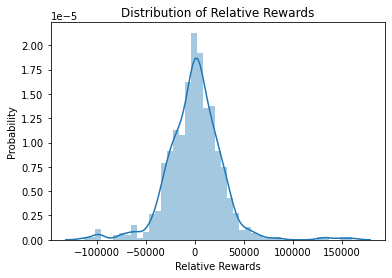

In [ ]:
ax = sns.distplot(relative_reward_list)
ax.set(title='Distribution of Relative Rewards',xlabel='Relative Rewards', ylabel='Probability')

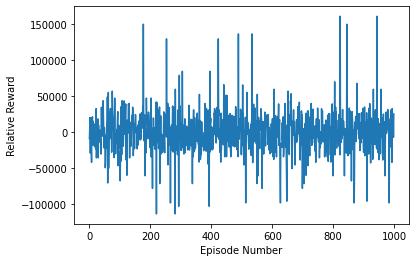

In [ ]:
ax= plt.plot(relative_reward_list)
plt.xlabel('Episode Number')
plt.ylabel('Relative Reward')
plt.savefig('abc.jpg')
# ax.set(title='Convergence of Relative Rewards',xlabel='Episode Number', ylabel='Relative Reward')

In [ ]:
np.nanmedian(relative_reward_list)

1008.962612994248

In [ ]:
np.nanmean(relative_reward_list)

-103.2486048374374

[Text(0, 0.5, 'Probability'),
 Text(0.5, 0, 'Rewards'),
 Text(0.5, 1.0, 'Distribution of Rewards')]

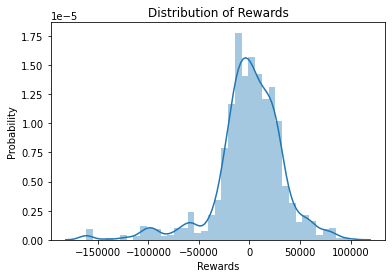

In [ ]:
ax= sns.distplot(reward_list)
ax.set(title='Distribution of Rewards',xlabel='Rewards', ylabel='Probability')

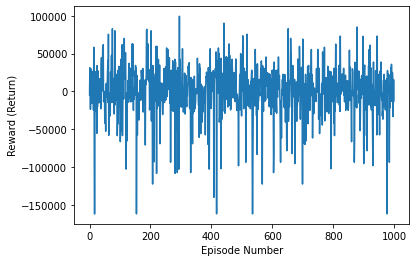

In [ ]:
plt.plot(reward_list)
plt.xlabel('Episode Number')
plt.ylabel('Reward (Return)')
plt.savefig('abc.jpg')


In [ ]:
np.nanmedian(reward_list)

768.9407763916533

In [ ]:
np.nanmean(reward_list)

-412.49035160144035

In [ ]:
np.nanstd(reward_list)

34071.700406967844

In [ ]:
np.nanstd(relative_reward_list)

28748.50269384324

In [ ]:
stats.ttest_1samp(np.array(relative_reward_list), 0)

Ttest_1sampResult(statistic=-0.11351459545042508, pvalue=0.9096453996675771)

In [ ]:
bse_reward_list = np.array(reward_list) - np.array(relative_reward_list)

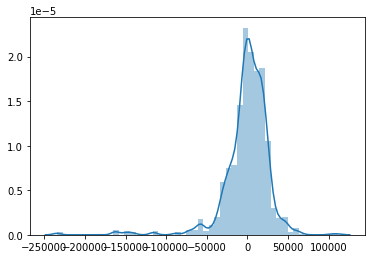

In [ ]:
sns.distplot(bse_reward_list)

In [ ]:
np.nanmedian(bse_reward_list)

2363.2358224999625

In [ ]:

np.nanmean(bse_reward_list)

-309.2417467640029

In [ ]:

np.nanstd(bse_reward_list)

28548.317617525412

# Train Env

In [ ]:
# actor_weights = os.path.join(weights, 'ddpg_actor_weights')
# critic_weights =os.path.join(weights, 'ddpg_critic_weights')

# actor.load_state_dict(torch.load(actor_weights))
# critic.load_state_dict(torch.load(critic_weights))

train_reward_list = []
train_relative_reward_list = []
for i_episode in range(1000):
    print('Episode '+str(i_episode)+' running\n')
    state = get_state_tensor(train_env.reset(worth))    
    episode_reward = 0
    relative_episode_reward = 0
    if train_env.date!=train_env.end_date:
        for t in range(1, 100):
            
            action = select_action(state)
            # print(train_env.share)
            # print(train_env.bse_worth)
            
            next_state, reward, bse_reward, utility, done = train_env.step(action) # env.step() takes numpy array as inputs
            episode_reward += reward
            relative_episode_reward += (reward - bse_reward)

            next_state = get_state_tensor(next_state)
            state = next_state

            if done:
                break  
#         print("Episode {} reward: {}".format(str(train_env.date), str(episode_reward)))
        
    train_reward_list += [episode_reward]
    train_relative_reward_list +=[relative_episode_reward]

Episode 0 running

Episode 1 running

Episode 2 running

Episode 3 running

Episode 4 running

Episode 5 running

Episode 6 running

Episode 7 running

Episode 8 running

Episode 9 running

Episode 10 running

Episode 11 running

Episode 12 running

Episode 13 running

Episode 14 running

Episode 15 running

Episode 16 running

Episode 17 running

Episode 18 running

Episode 19 running

Episode 20 running

Episode 21 running

Episode 22 running

Episode 23 running

Episode 24 running

Episode 25 running

Episode 26 running

Episode 27 running

Episode 28 running

Episode 29 running

Episode 30 running

Episode 31 running

Episode 32 running

Episode 33 running

Episode 34 running

Episode 35 running

Episode 36 running

Episode 37 running

Episode 38 running

Episode 39 running

Episode 40 running

Episode 41 running

Episode 42 running

Episode 43 running

Episode 44 running

Episode 45 running

Episode 46 running

Episode 47 running

Episode 48 running

Episode 49 running

Episode 50

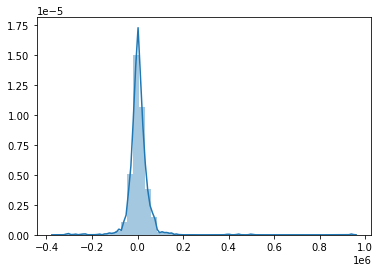

In [ ]:
sns.distplot(train_relative_reward_list)

In [ ]:
np.median(train_relative_reward_list)

2088.1162085542455

In [ ]:
np.mean(train_relative_reward_list)

4868.621960170633

In [ ]:
stats.ttest_1samp(np.array(reward_list), 0)

Ttest_1sampResult(statistic=-0.38265089229093857, pvalue=0.7020600267522767)

[Text(0, 0.5, 'Probability'),
 Text(0.5, 0, 'Relative Rewards'),
 Text(0.5, 1.0, 'Distribution of Relative Rewards')]

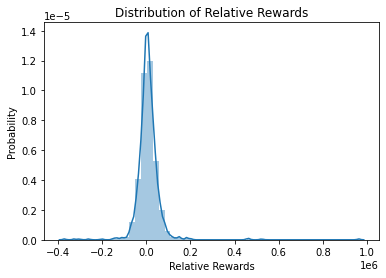

In [ ]:
ax= sns.distplot(train_reward_list)
ax.set(title='Distribution of Relative Rewards',xlabel='Relative Rewards', ylabel='Probability')

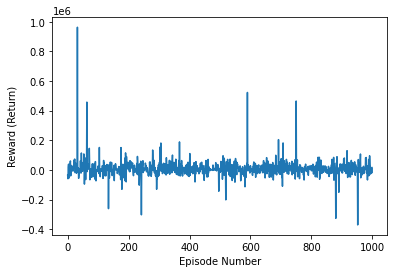

In [ ]:
plt.plot(train_reward_list)
plt.xlabel('Episode Number')
plt.ylabel('Reward (Return)')
plt.savefig('abc.jpg')

In [ ]:
np.median(train_reward_list)

4686.145282430865

In [ ]:
np.mean(train_reward_list)

8378.635466197635

In [ ]:
np.std(train_reward_list)

116617.77398310103